In [1]:
import numpy as np
import string
import random
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:

###############################################################################
# 1) Generate a synthetic RGB CAPTCHA dataset
###############################################################################

# Configuration
NUM_SAMPLES_TRAIN = 30000
NUM_SAMPLES_VAL   = 6000
NUM_SAMPLES_TEST  = 6000

IMG_WIDTH   = 100
IMG_HEIGHT  = 50
NUM_DIGITS  = 3   # We want a 3-digit captcha
CHARS       = list(string.digits)  # Digits [0-9]
FONT_PATH   = None  # Provide a TTF path if you have one, else use default font
FONT_SIZE   = 50

def random_color_range(low=0, high=255):
    """Generate a random (R, G, B) color."""
    return (
        random.randint(low, high),
        random.randint(low, high),
        random.randint(low, high)
    )

def generate_captcha_image_and_label():
    """Generate one RGB captcha image (PIL) and its 3-digit label string."""
    label_str = ''.join(random.choices(CHARS, k=NUM_DIGITS))

    # Create a blank RGB image
    img = Image.new('RGB', (IMG_WIDTH, IMG_HEIGHT), color=random_color_range(180,255))
    draw = ImageDraw.Draw(img)

    # If you have a specific TTF font file, load it:
    # font = ImageFont.truetype(FONT_PATH, FONT_SIZE) if FONT_PATH else ImageFont.load_default()
    font = ImageFont.load_default()

    # Draw each digit in the label
    for i, ch in enumerate(label_str):
        x = 5 + i * (IMG_WIDTH // NUM_DIGITS)
        y = random.randint(0, max(0, IMG_HEIGHT - FONT_SIZE))
        draw.text((x, y), ch, font=font, fill=random_color_range(0,150))

    # Optional: add some noise lines
    for _ in range(random.randint(1,5)):
        start = (random.randint(0, IMG_WIDTH//2), random.randint(0, IMG_HEIGHT))
        end   = (random.randint(0, IMG_WIDTH//2), random.randint(0, IMG_HEIGHT))
        draw.line([start, end], fill=random_color_range(0,255), width=1)

    return img, label_str

def create_dataset(num_samples):
    """
    Returns:
       X: Array of shape (num_samples, H, W, 3)
       y1, y2, y3: Each is one-hot of shape (num_samples, 10)
    """
    X = np.zeros((num_samples, IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.uint8)
    y_digit1 = np.zeros((num_samples, 10), dtype=np.float32)
    y_digit2 = np.zeros((num_samples, 10), dtype=np.float32)
    y_digit3 = np.zeros((num_samples, 10), dtype=np.float32)

    for i in range(num_samples):
        img, label_str = generate_captcha_image_and_label()
        X[i] = np.array(img)

        # One-hot for each digit
        y_digit1[i, int(label_str[0])] = 1.0
        y_digit2[i, int(label_str[1])] = 1.0
        y_digit3[i, int(label_str[2])] = 1.0

    return X, y_digit1, y_digit2, y_digit3

print("Generating training dataset...")
X_train_np, y1_train_np, y2_train_np, y3_train_np = create_dataset(NUM_SAMPLES_TRAIN)
print("Generating validation dataset...")
X_val_np,   y1_val_np,  y2_val_np,  y3_val_np  = create_dataset(NUM_SAMPLES_VAL)
print("Generating test dataset...")
X_test_np,  y1_test_np, y2_test_np, y3_test_np = create_dataset(NUM_SAMPLES_TEST)

# Normalize images to [0,1] float
X_train_np = X_train_np.astype('float32') / 255.
X_val_np   = X_val_np.astype('float32') / 255.
X_test_np  = X_test_np.astype('float32') / 255.


Generating training dataset...
Generating validation dataset...
Generating test dataset...


In [3]:

###############################################################################
# 2) Create a PyTorch Dataset and DataLoader
###############################################################################
class CaptchaDataset(Dataset):
    def __init__(self, X, y1, y2, y3):
        # X shape: (N, H, W, 3)
        # y1, y2, y3 each shape: (N, 10)
        self.X = X
        self.y1 = y1
        self.y2 = y2
        self.y3 = y3

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        # Convert from H,W,3 to 3,H,W for PyTorch
        img = torch.tensor(np.transpose(self.X[idx], (2,0,1)), dtype=torch.float32)
        d1  = torch.tensor(self.y1[idx], dtype=torch.float32)
        d2  = torch.tensor(self.y2[idx], dtype=torch.float32)
        d3  = torch.tensor(self.y3[idx], dtype=torch.float32)
        return img, d1, d2, d3

train_dataset = CaptchaDataset(X_train_np, y1_train_np, y2_train_np, y3_train_np)
val_dataset   = CaptchaDataset(X_val_np,   y1_val_np,  y2_val_np,  y3_val_np)
test_dataset  = CaptchaDataset(X_test_np,  y1_test_np, y2_test_np, y3_test_np)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)


In [4]:

print("Size of train_dataset:", len(train_dataset))
print("Size of val_dataset:", len(val_dataset))
print("Size of test_dataset:", len(test_dataset))


Size of train_dataset: 30000
Size of val_dataset: 6000
Size of test_dataset: 6000


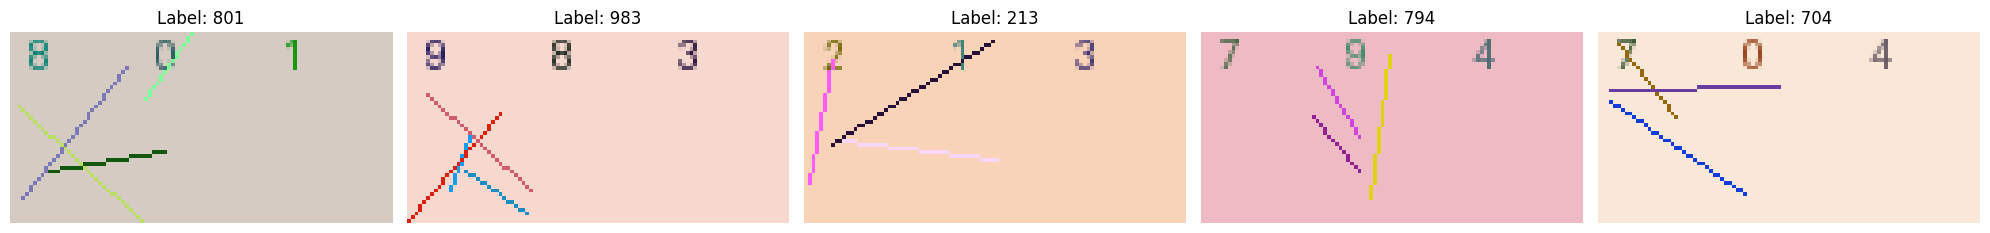

In [5]:
def show_dataset_samples(dataset, num_samples=5):
    """
    Randomly picks 'num_samples' items from the dataset and displays them.
    For each sample, we show:
     - the CAPTCHA image
     - the one-hot labels for digit1, digit2, digit3
    """
    indices = np.random.choice(len(dataset), size=num_samples, replace=False)
    fig, axes = plt.subplots(1, num_samples, figsize=(4*num_samples, 4))

    for i, idx in enumerate(indices):
        img, d1, d2, d3 = dataset[idx]  # Each 'dX' is a 10-dimensional one-hot
        # Convert (3,H,W) tensor to (H,W,3) for plotting
        img_np = img.permute(1, 2, 0).numpy()

        # Each digit's label is the index of the '1' in the one-hot vector.
        digit1 = torch.argmax(d1).item()
        digit2 = torch.argmax(d2).item()
        digit3 = torch.argmax(d3).item()

        axes[i].imshow(img_np)
        axes[i].axis("off")
        axes[i].set_title(f"Label: {digit1}{digit2}{digit3}")

    plt.tight_layout()
    plt.show()

show_dataset_samples(train_dataset, num_samples=5)

In [6]:

###############################################################################
# 3) Define the CNN model in PyTorch (3 separate heads, one for each digit)
###############################################################################
class CaptchaNet(nn.Module):
    def __init__(self):
        super(CaptchaNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # After 3 pooling layers, the input dimension is reduced by 2^3 = 8
        # So final feature map size is (IMG_HEIGHT/8) x (IMG_WIDTH/8)
        # For 50x100 -> 6 x 12 if it divides evenly (some rounding differences).
        # We'll do integer division and see if that works out:
        fc_input_dim = 128 * (IMG_HEIGHT // 8) * (IMG_WIDTH // 8)
        self.fc1 = nn.Linear(fc_input_dim, 256)

        # Three "heads" -> each 10-way for digits 0..9
        self.digit1 = nn.Linear(256, 10)
        self.digit2 = nn.Linear(256, 10)
        self.digit3 = nn.Linear(256, 10)

    def forward(self, x):
        # x: (N, 3, H, W)
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)

        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))

        out1 = self.digit1(x)
        out2 = self.digit2(x)
        out3 = self.digit3(x)
        return out1, out2, out3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CaptchaNet().to(device)

# We'll use standard cross-entropy (logits -> cross_entropy).
# Because each digit head is 10-class classification, we do them separately.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [7]:

###############################################################################
# 4) Training Loop
###############################################################################
def train_one_epoch(model, dataloader, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, y1, y2, y3 in dataloader:
        images = images.to(device)
        y1 = y1.to(device)
        y2 = y2.to(device)
        y3 = y3.to(device)

        optimizer.zero_grad()
        out1, out2, out3 = model(images)

        # Each out shape: (batch_size, 10), each y shape: (batch_size, 10)
        # We have one-hot labels, but nn.CrossEntropyLoss expects class indices.
        # Convert one-hot to class indices using argmax.
        target1 = torch.argmax(y1, dim=1)
        target2 = torch.argmax(y2, dim=1)
        target3 = torch.argmax(y3, dim=1)

        loss1 = criterion(out1, target1)
        loss2 = criterion(out2, target2)
        loss3 = criterion(out3, target3)
        loss = loss1 + loss2 + loss3

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(dataloader)

def evaluate(model, dataloader, device):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, y1, y2, y3 in dataloader:
            images = images.to(device)
            y1 = y1.to(device)
            y2 = y2.to(device)
            y3 = y3.to(device)

            out1, out2, out3 = model(images)
            target1 = torch.argmax(y1, dim=1)
            target2 = torch.argmax(y2, dim=1)
            target3 = torch.argmax(y3, dim=1)

            loss1 = criterion(out1, target1)
            loss2 = criterion(out2, target2)
            loss3 = criterion(out3, target3)
            loss = loss1 + loss2 + loss3
            val_loss += loss.item()
    return val_loss / len(dataloader)


In [8]:

num_epochs = 30
train_losses = []
val_losses = []

print("Starting training...")
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, device)
    val_loss = evaluate(model, val_loader, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_loss:.4f} - "
          f"Val Loss: {val_loss:.4f}")


Starting training...
Epoch 1/30 - Train Loss: 2.0856 - Val Loss: 0.1134
Epoch 2/30 - Train Loss: 0.0807 - Val Loss: 0.0717
Epoch 3/30 - Train Loss: 0.0459 - Val Loss: 0.0716
Epoch 4/30 - Train Loss: 0.0313 - Val Loss: 0.0719
Epoch 5/30 - Train Loss: 0.0235 - Val Loss: 0.0576
Epoch 6/30 - Train Loss: 0.0219 - Val Loss: 0.0622
Epoch 7/30 - Train Loss: 0.0158 - Val Loss: 0.0532
Epoch 8/30 - Train Loss: 0.0144 - Val Loss: 0.0525
Epoch 9/30 - Train Loss: 0.0149 - Val Loss: 0.0543
Epoch 10/30 - Train Loss: 0.0123 - Val Loss: 0.0641
Epoch 11/30 - Train Loss: 0.0103 - Val Loss: 0.0414
Epoch 12/30 - Train Loss: 0.0122 - Val Loss: 0.0327
Epoch 13/30 - Train Loss: 0.0119 - Val Loss: 0.0540
Epoch 14/30 - Train Loss: 0.0087 - Val Loss: 0.0485
Epoch 15/30 - Train Loss: 0.0074 - Val Loss: 0.0385
Epoch 16/30 - Train Loss: 0.0088 - Val Loss: 0.0326
Epoch 17/30 - Train Loss: 0.0074 - Val Loss: 0.0436
Epoch 18/30 - Train Loss: 0.0118 - Val Loss: 0.0604
Epoch 19/30 - Train Loss: 0.0045 - Val Loss: 0.0458


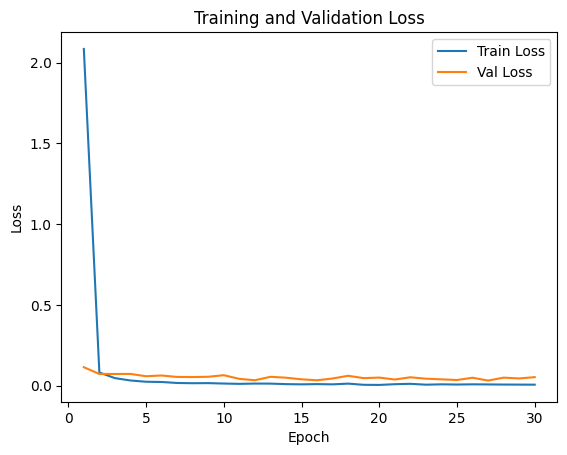

In [9]:

###############################################################################
# 5) Plot the training and validation loss
###############################################################################
plt.figure()
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()



Exact-match accuracy across all 3 digits: 99.22%


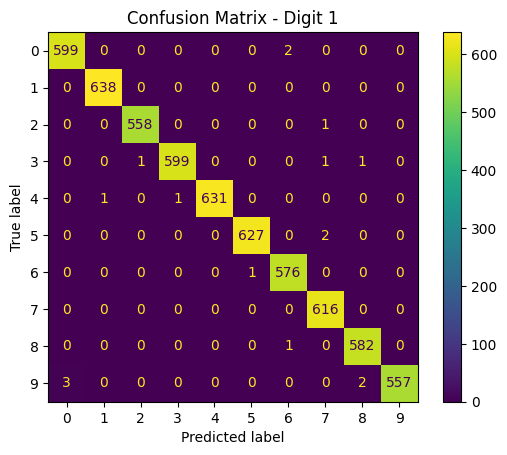

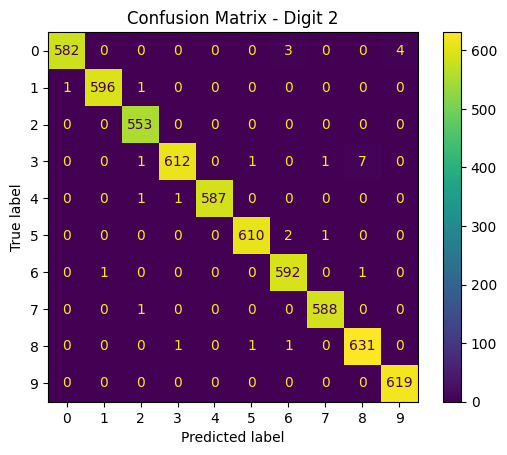

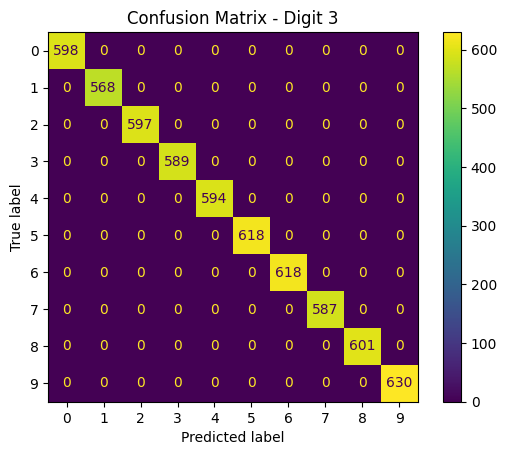

In [10]:

###############################################################################
# 6) Evaluate on the Test Set: Accuracy + Confusion Matrix
###############################################################################
model.eval()

all_pred1 = []
all_pred2 = []
all_pred3 = []
all_true1 = []
all_true2 = []
all_true3 = []

with torch.no_grad():
    for images, y1, y2, y3 in test_loader:
        images = images.to(device)
        y1 = y1.to(device)
        y2 = y2.to(device)
        y3 = y3.to(device)

        out1, out2, out3 = model(images)

        # Convert to predicted digit
        pred1 = torch.argmax(out1, dim=1)
        pred2 = torch.argmax(out2, dim=1)
        pred3 = torch.argmax(out3, dim=1)

        # True classes
        true1 = torch.argmax(y1, dim=1)
        true2 = torch.argmax(y2, dim=1)
        true3 = torch.argmax(y3, dim=1)

        all_pred1.append(pred1.cpu().numpy())
        all_pred2.append(pred2.cpu().numpy())
        all_pred3.append(pred3.cpu().numpy())

        all_true1.append(true1.cpu().numpy())
        all_true2.append(true2.cpu().numpy())
        all_true3.append(true3.cpu().numpy())

# Concatenate all batches
all_pred1 = np.concatenate(all_pred1)
all_pred2 = np.concatenate(all_pred2)
all_pred3 = np.concatenate(all_pred3)

all_true1 = np.concatenate(all_true1)
all_true2 = np.concatenate(all_true2)
all_true3 = np.concatenate(all_true3)

# Overall exact-match accuracy: all 3 digits must match
all_correct = (all_pred1 == all_true1) & (all_pred2 == all_true2) & (all_pred3 == all_true3)
exact_match_acc = np.mean(all_correct)
print(f"\nExact-match accuracy across all 3 digits: {exact_match_acc*100:.2f}%")

# Confusion matrices for each digit
for i, (preds, trues) in enumerate(zip([all_pred1, all_pred2, all_pred3],
                                       [all_true1, all_true2, all_true3]), start=1):
    cm = confusion_matrix(trues, preds, labels=range(10))
    disp = ConfusionMatrixDisplay(cm, display_labels=range(10))
    disp.plot(values_format='d')
    plt.title(f"Confusion Matrix - Digit {i}")
    plt.show()

In [75]:
# Check device availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Move model to the appropriate device
model = model.to(device)

def FGSM_targeted(model, x, y1, y2, y3, epsilon=0.1):
    x_adv = x.clone().detach().requires_grad_(True) # clone and set requires_grad
    y1=y1.to(device)
    y2=y2.to(device)
    y3=y3.to(device)
    output1, output2, output3 = model(x_adv)
    loss1 = nn.CrossEntropyLoss()(output1, y1)
    loss2 = nn.CrossEntropyLoss()(output2, y2)
    loss3 = nn.CrossEntropyLoss()(output3, y3)
    total_loss = loss1 + loss2 + loss3
    model.zero_grad()
    total_loss.backward()
    x_adv = x_adv - epsilon * x_adv.grad.sign()
    x_adv = torch.clamp(x_adv, 0, 1)
    return x_adv

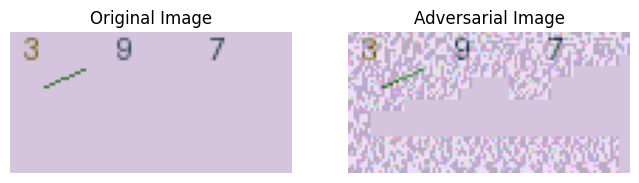

In [76]:
# Select a sample image from test dataset
sample_idx = 0  # Choose any test image
img, d1, d2, d3 = test_dataset[sample_idx]  # Load image and labels

# Convert one-hot labels to class indices
y1 = torch.argmax(d1).unsqueeze(0).to(device)  # First digit label
y2 = torch.argmax(d2).unsqueeze(0).to(device)  # Second digit label
y3 = torch.argmax(d3).unsqueeze(0).to(device)  # Third digit label

# Convert input to batch format and move to device
x_input = img.unsqueeze(0).to(device)

# Apply FGSM attack on the first digit classification
x_adv = FGSM_targeted(model, x_input, y1, y2, y3, epsilon=0.1)

# Move tensors back to CPU for visualization
x_input_cpu = x_input.cpu().squeeze().permute(1, 2, 0).detach().numpy()
x_adv_cpu = x_adv.cpu().squeeze().permute(1, 2, 0).detach().numpy()

# Display Original and Adversarial Images
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(x_input_cpu)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(x_adv_cpu)
axes[1].set_title("Adversarial Image")
axes[1].axis("off")

plt.show()

In [77]:
# Check device availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Move model to the appropriate device
model = model.to(device)

def FGSM_untargeted(model, x, y1, y2, y3, epsilon=0.1):
    x_adv = x.clone().detach().requires_grad_(True) # clone and set requires_grad
    y1=y1.to(device)
    y2=y2.to(device)
    y3=y3.to(device)
    output1, output2, output3 = model(x_adv)
    loss1 = nn.CrossEntropyLoss()(output1, y1)
    loss2 = nn.CrossEntropyLoss()(output2, y2)
    loss3 = nn.CrossEntropyLoss()(output3, y3)
    total_loss = loss1 + loss2 + loss3
    model.zero_grad()
    total_loss.backward()
    x_adv = x_adv + epsilon * x_adv.grad.sign()
    x_adv = torch.clamp(x_adv, 0, 1)
    return x_adv

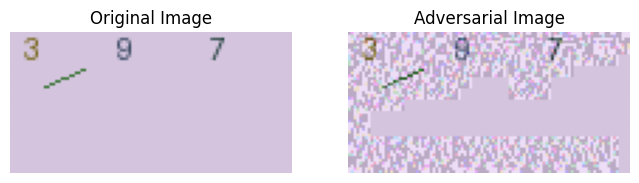

In [79]:
# Select a sample image from test dataset
sample_idx = 0  # Choose any test image
img, d1, d2, d3 = test_dataset[sample_idx]  # Load image and labels

# Convert one-hot labels to class indices
y1 = torch.argmax(d1).unsqueeze(0).to(device)  # First digit label
y2 = torch.argmax(d2).unsqueeze(0).to(device)  # Second digit label
y3 = torch.argmax(d3).unsqueeze(0).to(device)  # Third digit label

# Convert input to batch format and move to device
x_input = img.unsqueeze(0).to(device)

# Apply FGSM attack on the first digit classification
x_adv = FGSM_untargeted(model, x_input, y1, y2, y3, epsilon=0.1)

# Move tensors back to CPU for visualization
x_input_cpu = x_input.cpu().squeeze().permute(1, 2, 0).detach().numpy()
x_adv_cpu = x_adv.cpu().squeeze().permute(1, 2, 0).detach().numpy()

# Display Original and Adversarial Images
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(x_input_cpu)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(x_adv_cpu)
axes[1].set_title("Adversarial Image")
axes[1].axis("off")

plt.show()


Exact-match accuracy after untargeted FGSM attack: 14.48%


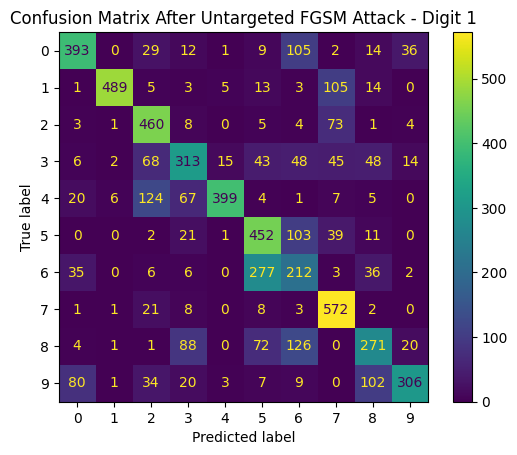

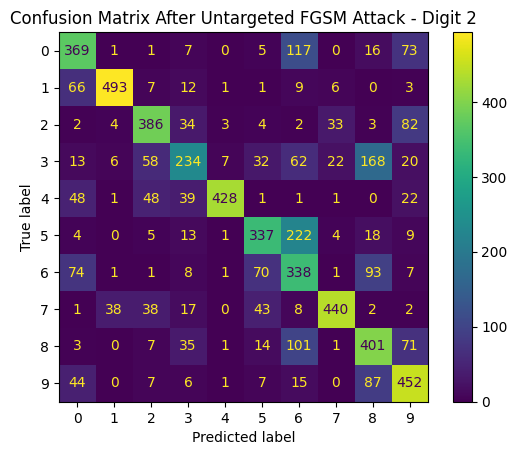

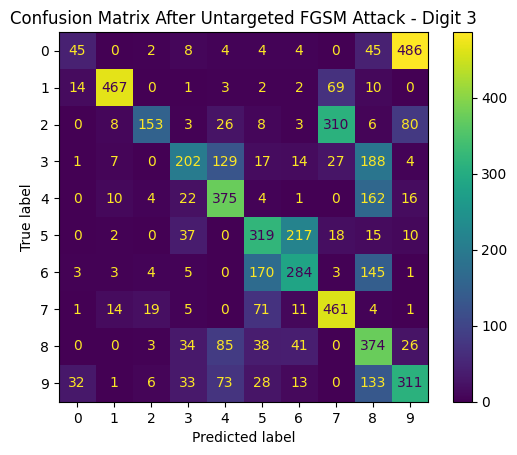

In [80]:
model.eval()

all_pred1_adv, all_pred2_adv, all_pred3_adv = [], [], []
all_true1_adv, all_true2_adv, all_true3_adv = [], [], []

for images, y1, y2, y3 in test_loader:
    images, y1, y2, y3 = images.to(device), y1.to(device), y2.to(device), y3.to(device)

    # Generate adversarial images using your untargeted FGSM attack
    images_adv = FGSM_untargeted(model, images, y1.argmax(dim=1), y2.argmax(dim=1), y3.argmax(dim=1), epsilon=0.1)

    # Predict using adversarial images
    with torch.no_grad():
        out1_adv, out2_adv, out3_adv = model(images_adv)

    # Predicted labels from adversarial examples
    pred1_adv = torch.argmax(out1_adv, dim=1).cpu().numpy()
    pred2_adv = torch.argmax(out2_adv, dim=1).cpu().numpy()
    pred3_adv = torch.argmax(out3_adv, dim=1).cpu().numpy()

    # True labels
    true1_adv = torch.argmax(y1, dim=1).cpu().numpy()
    true2_adv = torch.argmax(y2, dim=1).cpu().numpy()
    true3_adv = torch.argmax(y3, dim=1).cpu().numpy()

    # Collect predictions and labels
    all_pred1_adv.append(pred1_adv)
    all_pred2_adv.append(pred2_adv)
    all_pred3_adv.append(pred3_adv)

    all_true1_adv.append(true1_adv)
    all_true2_adv.append(true2_adv)
    all_true3_adv.append(true3_adv)

# Concatenate all batches
all_pred1_adv = np.concatenate(all_pred1_adv)
all_pred2_adv = np.concatenate(all_pred2_adv)
all_pred3_adv = np.concatenate(all_pred3_adv)

all_true1_adv = np.concatenate(all_true1_adv)
all_true2_adv = np.concatenate(all_true2_adv)
all_true3_adv = np.concatenate(all_true3_adv)

# Compute exact-match accuracy after the untargeted FGSM attack
all_correct_adv = (all_pred1_adv == all_true1_adv) & \
                  (all_pred2_adv == all_true2_adv) & \
                  (all_pred3_adv == all_true3_adv)
exact_match_acc_adv = np.mean(all_correct_adv)
print(f"\nExact-match accuracy after untargeted FGSM attack: {exact_match_acc_adv*100:.2f}%")

# Confusion matrices after the untargeted FGSM attack
for i, (preds, trues) in enumerate(zip([all_pred1_adv, all_pred2_adv, all_pred3_adv],
                                       [all_true1_adv, all_true2_adv, all_true3_adv]), start=1):
    cm = confusion_matrix(trues, preds, labels=range(10))
    disp = ConfusionMatrixDisplay(cm, display_labels=range(10))
    disp.plot(values_format='d')
    plt.title(f"Confusion Matrix After Untargeted FGSM Attack - Digit {i}")
    plt.show()


Exact-match accuracy after targeted FGSM attack: 5.07%


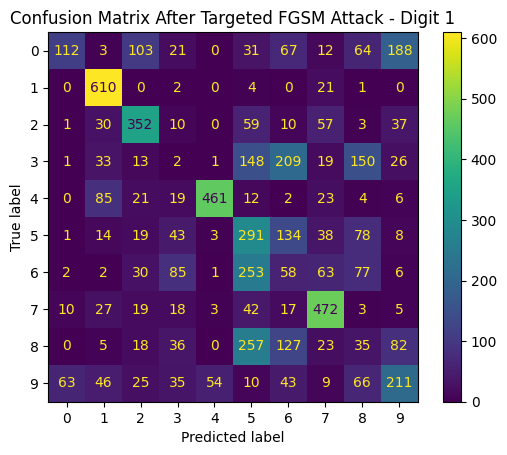

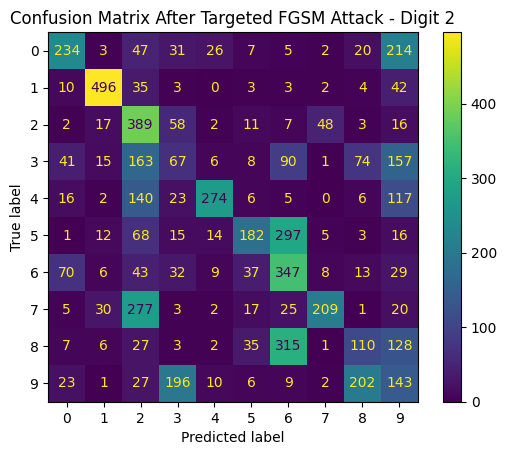

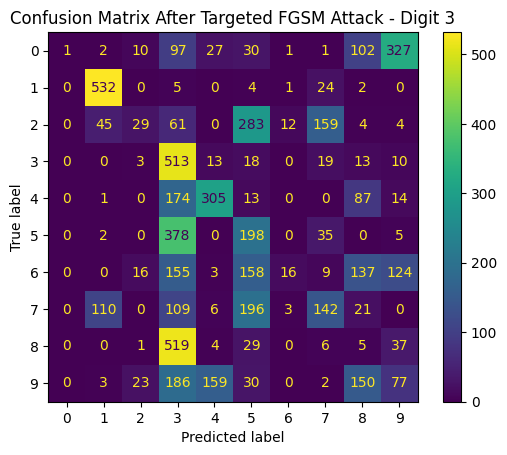

In [85]:
# Define targeted labels
target_digit1 = 1
target_digit2 = 2
target_digit3 = 3

model.eval()

# Containers to store predictions and true values after attack
all_pred1_adv, all_pred2_adv, all_pred3_adv = [], [], []
all_true1_adv, all_true2_adv, all_true3_adv = [], [], []

for images, y1, y2, y3 in test_loader:
    images, y1, y2, y3 = images.to(device), y1.to(device), y2.to(device), y3.to(device)

    # Create target labels (all zeros) matching current batch size
    batch_size_curr = images.size(0)
    y_target1 = torch.full((batch_size_curr,), target_digit1, dtype=torch.long).to(device)
    y_target2 = torch.full((batch_size_curr,), target_digit2, dtype=torch.long).to(device)
    y_target3 = torch.full((batch_size_curr,), target_digit3, dtype=torch.long).to(device)

    # Generate adversarial images using your targeted FGSM
    images_adv = FGSM_targeted(model, images, y_target1, y_target2, y_target3, epsilon=0.1)

    # Predict using adversarial images
    with torch.no_grad():
        out1_adv, out2_adv, out3_adv = model(images_adv)

    # Predicted labels from adversarial examples
    pred1_adv = torch.argmax(out1_adv, dim=1).cpu().numpy()
    pred2_adv = torch.argmax(out2_adv, dim=1).cpu().numpy()
    pred3_adv = torch.argmax(out3_adv, dim=1).cpu().numpy()

    # True labels
    true1_adv = torch.argmax(y1, dim=1).cpu().numpy()
    true2_adv = torch.argmax(y2, dim=1).cpu().numpy()
    true3_adv = torch.argmax(y3, dim=1).cpu().numpy()

    # Collect predictions and labels
    all_pred1_adv.append(pred1_adv)
    all_pred2_adv.append(pred2_adv)
    all_pred3_adv.append(pred3_adv)

    all_true1_adv.append(true1_adv)
    all_true2_adv.append(true2_adv)
    all_true3_adv.append(true3_adv)

# Concatenate all batches
all_pred1_adv = np.concatenate(all_pred1_adv)
all_pred2_adv = np.concatenate(all_pred2_adv)
all_pred3_adv = np.concatenate(all_pred3_adv)

all_true1_adv = np.concatenate(all_true1_adv)
all_true2_adv = np.concatenate(all_true2_adv)
all_true3_adv = np.concatenate(all_true3_adv)

# Compute exact-match accuracy after the targeted FGSM attack
all_correct_adv = (all_pred1_adv == all_true1_adv) & \
                  (all_pred2_adv == all_true2_adv) & \
                  (all_pred3_adv == all_true3_adv)
exact_match_acc_adv = np.mean(all_correct_adv)
print(f"\nExact-match accuracy after targeted FGSM attack: {exact_match_acc_adv*100:.2f}%")

# Confusion matrices after the targeted FGSM attack
for i, (preds, trues) in enumerate(zip([all_pred1_adv, all_pred2_adv, all_pred3_adv],
                                       [all_true1_adv, all_true2_adv, all_true3_adv]), start=1):
    cm = confusion_matrix(trues, preds, labels=range(10))
    disp = ConfusionMatrixDisplay(cm, display_labels=range(10))
    disp.plot(values_format='d')
    plt.title(f"Confusion Matrix After Targeted FGSM Attack - Digit {i}")
    plt.show()